# Deep Autoencoding Gaussian Mixture Model for Unsupervised Anomaly Detection

In [1]:
import numpy as np 
import pandas as pd
import torch
from data_loader import * 
from main import *
from tqdm import tqdm
from sklearn.preprocessing import Imputer

## KDD Cup 1999 Data (10% subset)
This is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between "bad" connections, called intrusions or attacks, and "good" normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment. 

In [2]:
#WIndows
#transaction_data = pd.read_csv("C:/Users/cncluser/Downloads/ieee-fraud-detection/train_transaction.csv", header=0)
#macOS
transaction_data = pd.read_csv("/Users/nami/Downloads/ieee-fraud-detection/train_transaction.csv", header=0)

transaction_data

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Windows
#identity_data = pd.read_csv("C:/Users/cncluser/Downloads/ieee-fraud-detection/train_identity.csv", header=0)
#macOS
identity_data = pd.read_csv("/Users/nami/Downloads/ieee-fraud-detection/train_identity.csv", header=0)

identity_data

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,3577521,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,F3111 Build/33.3.A.1.97
144229,3577526,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN,NaN,...,chrome 55.0 for android,32.0,855x480,match_status:2,T,F,T,F,mobile,A574BL Build/NMF26F
144230,3577529,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN,NaN,...,chrome 65.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto E (4) Plus Build/NMA26.42-152
144231,3577531,-5.0,55528.0,0.0,0.0,0.0,-7.0,NaN,NaN,0.0,...,chrome 66.0,24.0,2560x1600,match_status:2,T,F,T,F,desktop,MacOS


In [4]:
data = transaction_data.set_index('TransactionID').join(identity_data.set_index('TransactionID'))
data

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Pre-processing
"isFraud" = 0 -> normal, "isFraud" = 1 -> anomaly. 

Next, the categorical variables are converted to a one hot encoding representation. My implementation is a bit different from the original paper in this aspect. Since I am only using the 10% subset to generate the columns, I get 118 features instead of 120 as reported in the paper.

In [5]:
one_hot_ProductCD = pd.get_dummies(data["ProductCD"])
one_hot_card4 = pd.get_dummies(data["card4"])
one_hot_card6 = pd.get_dummies(data["card6"])
one_hot_Pemaildomain = pd.get_dummies(data["P_emaildomain"])
one_hot_Remaildomain = pd.get_dummies(data["R_emaildomain"])
one_hot_M1 = pd.get_dummies(data["M1"])
one_hot_M2 = pd.get_dummies(data["M2"])
one_hot_M3 = pd.get_dummies(data["M3"])
one_hot_M4 = pd.get_dummies(data["M4"])
one_hot_M5 = pd.get_dummies(data["M5"])
one_hot_M6 = pd.get_dummies(data["M6"])
one_hot_M7 = pd.get_dummies(data["M7"])
one_hot_M8 = pd.get_dummies(data["M8"])
one_hot_M9 = pd.get_dummies(data["M9"])
one_hot_id12 = pd.get_dummies(data["id_12"])
one_hot_id15 = pd.get_dummies(data["id_15"])
one_hot_id16 = pd.get_dummies(data["id_16"])
one_hot_id23 = pd.get_dummies(data["id_23"])
one_hot_id27 = pd.get_dummies(data["id_27"])
one_hot_id28 = pd.get_dummies(data["id_28"])
one_hot_id29 = pd.get_dummies(data["id_29"])
one_hot_id30 = pd.get_dummies(data["id_30"])
one_hot_id31 = pd.get_dummies(data["id_31"])
one_hot_id33 = pd.get_dummies(data["id_33"])
one_hot_id34 = pd.get_dummies(data["id_34"])
one_hot_id35 = pd.get_dummies(data["id_35"])
one_hot_id36 = pd.get_dummies(data["id_36"])
one_hot_id37 = pd.get_dummies(data["id_37"])
one_hot_id38 = pd.get_dummies(data["id_38"])
one_hot_DeviceType = pd.get_dummies(data["DeviceType"])
one_hot_DeviceInfo = pd.get_dummies(data["DeviceInfo"])

In [6]:
data = data.drop("ProductCD",axis=1)
data = data.drop("card4",axis=1)
data = data.drop("card6",axis=1)
data = data.drop("P_emaildomain",axis=1)
data = data.drop("R_emaildomain",axis=1)
data = data.drop("M1",axis=1)
data = data.drop("M2",axis=1)
data = data.drop("M3",axis=1)
data = data.drop("M4",axis=1)
data = data.drop("M5",axis=1)
data = data.drop("M6",axis=1)
data = data.drop("M7",axis=1)
data = data.drop("M8",axis=1)
data = data.drop("M9",axis=1)
data = data.drop("id_12",axis=1)
data = data.drop("id_15",axis=1)
data = data.drop("id_16",axis=1)
data = data.drop("id_23",axis=1)
data = data.drop("id_27",axis=1)
data = data.drop("id_28",axis=1)
data = data.drop("id_29",axis=1)
data = data.drop("id_30",axis=1)
data = data.drop("id_31",axis=1)
data = data.drop("id_33",axis=1)
data = data.drop("id_34",axis=1)
data = data.drop("id_35",axis=1)
data = data.drop("id_36",axis=1)
data = data.drop("id_37",axis=1)
data = data.drop("id_38",axis=1)
data = data.drop("DeviceType",axis=1)
data = data.drop("DeviceInfo",axis=1)

In [7]:
data_header = data.columns
data_header = data_header.drop("isFraud")
#data_header

In [8]:
data = pd.concat([one_hot_ProductCD, one_hot_card4, one_hot_card6, 
                  one_hot_Pemaildomain, one_hot_Remaildomain, one_hot_M1, 
                  one_hot_M2, one_hot_M3, one_hot_M4, 
                  one_hot_M5, one_hot_M6, one_hot_M7, 
                  one_hot_M8, one_hot_M9, one_hot_id12, 
                  one_hot_id15, one_hot_id16, one_hot_id23, 
                  one_hot_id27, one_hot_id28, one_hot_id29, 
                  one_hot_id30, one_hot_id31, one_hot_id33, 
                  one_hot_id34, one_hot_id35, one_hot_id36, 
                  one_hot_id37, one_hot_id38, one_hot_DeviceType, 
                  one_hot_DeviceInfo, data],axis=1)
data.head()

,C,H,R,S,W,american express,discover,mastercard,visa,charge card,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,0,0,0,1,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,0,0,0,1,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,0,0,0,1,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,0,0,0,1,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,1,0,0,0,0,0,1,0,0,...,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,32.0


NaN -> mean

In [9]:
new_data = pd.DataFrame((Imputer(missing_values='NaN', strategy='mean').fit(data)).transform(data), columns=data.columns)
new_data.head()

/usr/local/var/pyenv/versions/anaconda3-2019.10/envs/dagmm/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,C,H,R,S,W,american express,discover,mastercard,visa,charge card,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,189.451377,14.237337,353.128174,403.882666,368.26982,16.002708,12.800927,329.608924,149.070308,26.508597
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,189.451377,14.237337,353.128174,403.882666,368.26982,16.002708,12.800927,329.608924,149.070308,26.508597
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,189.451377,14.237337,353.128174,403.882666,368.26982,16.002708,12.800927,329.608924,149.070308,26.508597
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,189.451377,14.237337,353.128174,403.882666,368.26982,16.002708,12.800927,329.608924,149.070308,26.508597
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,166.000000,14.237337,542.000000,144.000000,368.26982,16.002708,12.800927,329.608924,149.070308,32.000000


In [10]:
#new_data.loc[:,"SAMSUNG SM-G892A Build/NRD90M"]

In [11]:
proportions = new_data["isFraud"].value_counts()
print(proportions)
print("Anomaly Percentage",proportions[1] / proportions.sum())

0.0    569877
1.0     20663
Name: isFraud, dtype: int64
Anomaly Percentage 0.03499000914417313


In [12]:
#proportions_alfa = new_data["isFraud"].value_counts(normalize=True)
#print(proportions_alfa)

Normalize all the numeric variables.

In [13]:
cols_to_norm = data_header
print(cols_to_norm)

#new_data.loc[:, cols_to_norm] = (new_data[cols_to_norm] - new_data[cols_to_norm].mean()) / new_data[cols_to_norm].std()
min_cols = new_data.loc[new_data["isFraud"]==0 , cols_to_norm].min()
max_cols = new_data.loc[new_data["isFraud"]==0 , cols_to_norm].max()

new_data.loc[:, cols_to_norm] = (new_data[cols_to_norm] - min_cols) / (max_cols - min_cols)

Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
       'addr1', 'addr2', 'dist1', 'dist2',
       ...
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25',
       'id_26', 'id_32'],
      dtype='object', length=401)


In [14]:
print(min_cols)
print(max_cols)
new_data

TransactionDT     86400.000
TransactionAmt        0.251
card1              1000.000
card2               100.000
card3               100.000
                    ...    
id_22                10.000
id_24                11.000
id_25               100.000
id_26               100.000
id_32                 0.000
Length: 401, dtype: float64
TransactionDT     1.581113e+07
TransactionAmt    3.193739e+04
card1             1.839600e+04
card2             6.000000e+02
card3             2.310000e+02
                      ...     
id_22             4.400000e+01
id_24             2.600000e+01
id_25             5.480000e+02
id_26             2.160000e+02
id_32             3.200000e+01
Length: 401, dtype: float64


,C,H,R,S,W,american express,discover,mastercard,visa,charge card,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.693422,0.223018,0.443307,0.541680,0.355796,0.17655,0.120062,0.51252,0.42302,0.828394
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.693422,0.223018,0.443307,0.541680,0.355796,0.17655,0.120062,0.51252,0.42302,0.828394
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.693422,0.223018,0.443307,0.541680,0.355796,0.17655,0.120062,0.51252,0.42302,0.828394
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.693422,0.223018,0.443307,0.541680,0.355796,0.17655,0.120062,0.51252,0.42302,0.828394
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.511628,0.223018,0.774081,0.078431,0.355796,0.17655,0.120062,0.51252,0.42302,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.693422,0.223018,0.443307,0.541680,0.355796,0.17655,0.120062,0.51252,0.42302,0.828394
590536,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.693422,0.223018,0.443307,0.541680,0.355796,0.17655,0.120062,0.51252,0.42302,0.828394
590537,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.693422,0.223018,0.443307,0.541680,0.355796,0.17655,0.120062,0.51252,0.42302,0.828394
590538,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.693422,0.223018,0.443307,0.541680,0.355796,0.17655,0.120062,0.51252,0.42302,0.828394


I saved the preprocessed data into a numpy file format and load it using the pytorch data loader.

In [15]:
np.savez_compressed("ieee_fraud",ieee=new_data.as_matrix())

/usr/local/var/pyenv/versions/anaconda3-2019.10/envs/dagmm/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


I initially implemented this to be ran in the command line and use argparse to get the hyperparameters. To make it runnable in a jupyter notebook, I had to create a dummy class for the hyperparameters.

In [16]:
class hyperparams():
    def __init__(self, config):
        self.__dict__.update(**config)
defaults = {
    'lr' : 1e-4,
    'num_epochs' : 200,
    'batch_size' : 1024,
    'gmm_k' : 4,
    'lambda_energy' : 0.1,
    'lambda_cov_diag' : 0.005,
    'pretrained_model' : None,
    'mode' : 'train',
    'use_tensorboard' : False,
    'data_path' : 'ieee_fraud.npz',

    'log_path' : './dagmm/ieee_logs',
    'model_save_path' : './dagmm/ieee_models',
    'sample_path' : './dagmm/ieee_samples',
    'test_sample_path' : './dagmm/ieee_test_samples',
    'result_path' : './dagmm/ieee_results',

    'log_step' : 194//4,
    'sample_step' : 194,
    'model_save_step' : 194,
}

In [17]:
solver = main(hyperparams(defaults))
accuracy, precision, recall, f_score = solver.test()

data_path of getloder = ieee_fraud.npz
data_path of loader = ieee_fraud.npz


  0%|          | 0/1 [00:00<?, ?it/s]

data_path of main : ieee_fraud.npz
DaGMM
DaGMM(
  (encoder): Sequential(
    (0): Linear(in_features=2833, out_features=1420, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1420, out_features=710, bias=True)
    (3): Tanh()
    (4): Linear(in_features=710, out_features=350, bias=True)
    (5): Tanh()
    (6): Linear(in_features=350, out_features=170, bias=True)
    (7): Tanh()
    (8): Linear(in_features=170, out_features=80, bias=True)
    (9): Tanh()
    (10): Linear(in_features=80, out_features=40, bias=True)
    (11): Tanh()
    (12): Linear(in_features=40, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=10, bias=True)
    (15): Tanh()
    (16): Linear(in_features=10, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=40, bias=True)
 

  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1159],
        [-0.1174],
        [-0.1122]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-43.1763, -41.5606, -41.2819], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(5160.4028, grad_fn=<AddBackward0>)
tensor(-42.0063, grad_fn=<MeanBackward0>)
tensor(0.0165, grad_fn=<MeanBackward0>)
tensor(1032917.4375, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1176],
        [-0.1199],
        [-0.1103]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-42.1211, -42.5466, -42.0688], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(3070.0852, grad_fn=<AddBackward0>)
tensor(-42.2455, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(614858.6250, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1216],
        [-0.1191],
        [-0.1091]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-41.2572,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0171, grad_fn=<MeanBackward0>)
tensor(640182.6250, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1206],
        [-0.1232],
        [-0.1078]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-43.7231, -42.8945, -43.2294], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(5523.2026, grad_fn=<AddBackward0>)
tensor(-43.2823, grad_fn=<MeanBackward0>)
tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(1105502.6250, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1219],
        [-0.1063],
        [-0.1248]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-40.3981, -42.1749, -41.0750], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(2560.6365, grad_fn=<AddBackward0>)
tensor(-41.2160, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(512948.0625, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1050],
        [-0.1227],
        [-0.1257]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan,      nan, -36.2222], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(171419.4531, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1273],
        [-0.1241],
        [-0.1036]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -35.0318,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0186, grad_fn=<MeanBackward0>)
tensor(121732.9219, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1246],
        [-0.1279],
        [-0.1027]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(86056.7031, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1245],
        [-0.1276],
        [-0.1024]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)
tensor(66262.7578, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1282],
        [-0.1250],
        [-0.1017]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0192, grad_fn=<MeanBackward0>)
tensor(56017.7344, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1016],
        [-0.1279],
        [-0.1249]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan,      nan, -35.8131], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0193, grad_fn=<MeanBackward0>)
tensor(51364.5625, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1269],
        [-0.1242],
        [-0.1020]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-37.9488, -36.7375, -38.6396], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(249.1379, grad_fn=<AddBackward0>)
tensor(-37.7753, grad_fn=<MeanBackward0>)
tensor(0.0192, grad_fn=<MeanBackward0>)
tensor(50579.2500, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1267],
        [-0.1018],
        [-0.1239]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-35.3581, -36.5530, -36.7833], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(226.9556, grad_fn=<AddBackward0>)
tensor(-36.2315, grad_fn=<MeanBackward0>)
tensor(0.0193, grad_fn=<MeanBackward0>)
tensor(46111.8789, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1242],
        [-0.1274],
        [-0.1012]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -34.7452, -36.0885], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0195, grad_fn=<MeanBackward0>)
tensor(43221.7852, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1273],
        [-0.1238],
        [-0.1010]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-36.9874, -37.9055, -34.7200], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(206.7947, grad_fn=<AddBackward0>)
tensor(-36.5376, grad_fn=<MeanBackward0>)
tensor(0.0196, grad_fn=<MeanBackward0>)
tensor(42085.7812, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1004],
        [-0.1240],
        [-0.1279]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-37.6906, -36.0956, -36.4151], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(188.3512, grad_fn=<AddBackward0>)
tensor(-36.7338, grad_fn=<MeanBackward0>)
tensor(0.0198, grad_fn=<MeanBackward0>)
tensor(38400.9688, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1003],
        [-0.1236],
        [-0.1277]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-38.3494, -37.4287, -37.1614], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(185.6741, grad_fn=<AddBackward0>)
tensor(-37.6465, grad_fn=<MeanBackward0>)
tensor(0.0198, grad_fn=<MeanBackward0>)
tensor(37883.7852, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1267],
        [-0.1005],
        [-0.1227]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0198, grad_fn=<MeanBackward0>)
tensor(39585.5430, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1213],
        [-0.1009],
        [-0.1252]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-36.0161, -37.6763, -36.1925], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(215.2863, grad_fn=<AddBackward0>)
tensor(-36.6283, grad_fn=<MeanBackward0>)
tensor(0.0197, grad_fn=<MeanBackward0>)
tensor(43785.8906, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1011],
        [-0.1247],
        [-0.1207]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-35.9317, -36.4539, -36.1769], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(232.9951, grad_fn=<AddBackward0>)
tensor(-36.1875, grad_fn=<MeanBackward0>)
tensor(0.0197, grad_fn=<MeanBackward0>)
tensor(47318.8438, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1014],
        [-0.1236],
        [-0.1196]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-33.2678,      nan, -35.2833], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0196, grad_fn=<MeanBackward0>)
tensor(51875.8594, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1182],
        [-0.1220],
        [-0.1019]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan,      nan, -32.9001], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0195, grad_fn=<MeanBackward0>)
tensor(62178.4961, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1177],
        [-0.1215],
        [-0.1022]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-35.7731, -34.1949,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(61936.7188, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1027],
        [-0.1204],
        [-0.1168]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(76434.9062, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1033],
        [-0.1189],
        [-0.1156]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -36.3735, -36.7199], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(101403.6172, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1036],
        [-0.1183],
        [-0.1151]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-35.6607, -34.2107, -33.4965], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(570.2416, grad_fn=<AddBackward0>)
tensor(-34.4559, grad_fn=<MeanBackward0>)
tensor(0.0193, grad_fn=<MeanBackward0>)
tensor(114733.5859, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1041],
        [-0.1172],
        [-0.1144]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-35.2523, -35.7524, -35.4976], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(652.6525, grad_fn=<AddBackward0>)
tensor(-35.5008, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(131236.6406, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1043],
        [-0.1141],
        [-0.1169]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-33.9242, -35.2698, -35.0650], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(716.3071, grad_fn=<AddBackward0>)
tensor(-34.7530, grad_fn=<MeanBackward0>)
tensor(0.0193, grad_fn=<MeanBackward0>)
tensor(143952.6094, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1162],
        [-0.1047],
        [-0.1136]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(171887.5469, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1129],
        [-0.1052],
        [-0.1151]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-34.3823, -75.7791,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0196, grad_fn=<MeanBackward0>)
tensor(231448.1406, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1055],
        [-0.1147],
        [-0.1126]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0196, grad_fn=<MeanBackward0>)
tensor(264902.3750, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1055],
        [-0.1126],
        [-0.1147]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -34.4121, -34.8136], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0196, grad_fn=<MeanBackward0>)
tensor(274205.9688, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1144],
        [-0.1124],
        [-0.1057]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-37.6609, -36.5497,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0196, grad_fn=<MeanBackward0>)
tensor(297780.0312, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1124],
        [-0.1057],
        [-0.1144]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-37.5762, -38.0389, -36.2238], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(1481.1672, grad_fn=<AddBackward0>)
tensor(-37.2796, grad_fn=<MeanBackward0>)
tensor(0.0196, grad_fn=<MeanBackward0>)
tensor(296975.1250, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1127],
        [-0.1055],
        [-0.1147]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-37.7322, -36.0149, -36.9745], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(1313.4822, grad_fn=<AddBackward0>)
tensor(-36.9072, grad_fn=<MeanBackward0>)
tensor(0.0195, grad_fn=<MeanBackward0>)
tensor(263430.6875, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1128],
        [-0.1147],
        [-0.1056]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan,      nan, -34.3030], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0195, grad_fn=<MeanBackward0>)
tensor(267289.7812, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1127],
        [-0.1143],
        [-0.1058]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-39.8935, -40.6323, -40.9347], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(1500.9180, grad_fn=<AddBackward0>)
tensor(-40.4868, grad_fn=<MeanBackward0>)
tensor(0.0195, grad_fn=<MeanBackward0>)
tensor(300989.4375, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1125],
        [-0.1061],
        [-0.1137]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-36.7882, -36.5626, -36.8146], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(1867.6881, grad_fn=<AddBackward0>)
tensor(-36.7218, grad_fn=<MeanBackward0>)
tensor(0.0197, grad_fn=<MeanBackward0>)
tensor(374268.1250, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1125],
        [-0.1062],
        [-0.1133]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-35.6348, -35.9713,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0198, grad_fn=<MeanBackward0>)
tensor(410547.9375, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1065],
        [-0.1123],
        [-0.1128]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0199, grad_fn=<MeanBackward0>)
tensor(512935.8438, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1126],
        [-0.1123],
        [-0.1066]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(528064.5625, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1068],
        [-0.1122],
        [-0.1122]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)
tensor(625084.8750, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1123],
        [-0.1068],
        [-0.1120]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-32.8232,      nan, -33.3324], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0203, grad_fn=<MeanBackward0>)
tensor(669228.5000, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1070],
        [-0.1116],
        [-0.1122]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-31.6370, -33.9581, -33.6554], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(3885.6907, grad_fn=<AddBackward0>)
tensor(-33.0835, grad_fn=<MeanBackward0>)
tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(777795.7500, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1122],
        [-0.1070],
        [-0.1114]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(804752.1875, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1123],
        [-0.1114],
        [-0.1066]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([ -39.9875,  -37.9192, -100.7597], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(3590.3010, grad_fn=<AddBackward0>)
tensor(-59.5555, grad_fn=<MeanBackward0>)
tensor(0.0211, grad_fn=<MeanBackward0>)
tensor(719247.0625, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1125],
        [-0.1061],
        [-0.1115]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-34.8848, -35.7909, -35.1220], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(2603.3833, grad_fn=<AddBackward0>)
tensor(-35.2659, grad_fn=<MeanBackward0>)
tensor(0.0222, grad_fn=<MeanBackward0>)
tensor(521377.5312, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1117],
        [-0.1126],
        [-0.1054]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0238, grad_fn=<MeanBackward0>)
tensor(394851.8125, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1045],
        [-0.1121],
        [-0.1129]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-33.7640, -33.1302,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0259, grad_fn=<MeanBackward0>)
tensor(296819.1875, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1134],
        [-0.1126],
        [-0.1035]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-33.8596, -37.0343,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0287, grad_fn=<MeanBackward0>)
tensor(203705.6094, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1024],
        [-0.1134],
        [-0.1140]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-35.7462,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0322, grad_fn=<MeanBackward0>)
tensor(148475.3906, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1016],
        [-0.1139],
        [-0.1145]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0355, grad_fn=<MeanBackward0>)
tensor(122641.4062, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1151],
        [-0.1007],
        [-0.1147]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-255.0347,       nan, -805.9487], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0393, grad_fn=<MeanBackward0>)
tensor(93756.2031, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1000],
        [-0.1152],
        [-0.1155]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-31.2215, -32.6818, -35.5676], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(396.9488, grad_fn=<AddBackward0>)
tensor(-33.1569, grad_fn=<MeanBackward0>)
tensor(0.0429, grad_fn=<MeanBackward0>)
tensor(80044.3203, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0992],
        [-0.1160],
        [-0.1162]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0469, grad_fn=<MeanBackward0>)
tensor(70956.3750, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1171],
        [-0.0984],
        [-0.1169]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -41.9827,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0516, grad_fn=<MeanBackward0>)
tensor(56948.2383, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0974],
        [-0.1180],
        [-0.1187]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0569, grad_fn=<MeanBackward0>)
tensor(45275.3242, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1188],
        [-0.0968],
        [-0.1198]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-32.5579, -36.7852, -34.3194], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(195.5209, grad_fn=<AddBackward0>)
tensor(-34.5542, grad_fn=<MeanBackward0>)
tensor(0.0617, grad_fn=<MeanBackward0>)
tensor(39782.9141, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1204],
        [-0.1191],
        [-0.0964]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-33.2808,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0659, grad_fn=<MeanBackward0>)
tensor(39108.0820, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0958],
        [-0.1214],
        [-0.1198]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-33.8392,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0704, grad_fn=<MeanBackward0>)
tensor(34857.8750, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1228],
        [-0.1208],
        [-0.0950]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-32.1493,      nan, -33.1422], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0753, grad_fn=<MeanBackward0>)
tensor(30838.9004, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0945],
        [-0.1237],
        [-0.1213]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0796, grad_fn=<MeanBackward0>)
tensor(28148.2656, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0944],
        [-0.1214],
        [-0.1241]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-37.4183, -33.5705, -32.3768], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(135.9476, grad_fn=<AddBackward0>)
tensor(-34.4552, grad_fn=<MeanBackward0>)
tensor(0.0831, grad_fn=<MeanBackward0>)
tensor(27861.9980, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0945],
        [-0.1210],
        [-0.1240]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-32.8710, -33.4553, -31.9472], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(133.9925, grad_fn=<AddBackward0>)
tensor(-32.7578, grad_fn=<MeanBackward0>)
tensor(0.0859, grad_fn=<MeanBackward0>)
tensor(27436.4844, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0944],
        [-0.1211],
        [-0.1244]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-31.6555,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0890, grad_fn=<MeanBackward0>)
tensor(26610.5586, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1243],
        [-0.0946],
        [-0.1209]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-32.8996, -32.5280, -33.1503], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(140.2898, grad_fn=<AddBackward0>)
tensor(-32.8593, grad_fn=<MeanBackward0>)
tensor(0.0914, grad_fn=<MeanBackward0>)
tensor(28696.8574, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0944],
        [-0.1246],
        [-0.1210]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0942, grad_fn=<MeanBackward0>)
tensor(27407.2598, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1214],
        [-0.0939],
        [-0.1252]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0974, grad_fn=<MeanBackward0>)
tensor(25145.1797, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1214],
        [-0.0938],
        [-0.1254]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.0997, grad_fn=<MeanBackward0>)
tensor(26133.3633, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1218],
        [-0.0934],
        [-0.1260]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-36.6601, -32.3006, -35.0935], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(125.5124, grad_fn=<AddBackward0>)
tensor(-34.6848, grad_fn=<MeanBackward0>)
tensor(0.1024, grad_fn=<MeanBackward0>)
tensor(25775.6914, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0926],
        [-0.1225],
        [-0.1270]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-35.3105, -30.8403, -31.0697], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(122.6635, grad_fn=<AddBackward0>)
tensor(-32.4068, grad_fn=<MeanBackward0>)
tensor(0.1055, grad_fn=<MeanBackward0>)
tensor(25159.7344, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0923],
        [-0.1228],
        [-0.1275]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1078, grad_fn=<MeanBackward0>)
tensor(23574.9336, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1235],
        [-0.0916],
        [-0.1284]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1105, grad_fn=<MeanBackward0>)
tensor(21386.9453, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0914],
        [-0.1288],
        [-0.1237]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-31.3151, -31.6671, -31.5879], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(104.6383, grad_fn=<AddBackward0>)
tensor(-31.5234, grad_fn=<MeanBackward0>)
tensor(0.1125, grad_fn=<MeanBackward0>)
tensor(21535.6367, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1243],
        [-0.0908],
        [-0.1296]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-31.9486, -32.6070,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1148, grad_fn=<MeanBackward0>)
tensor(21723.6270, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0896],
        [-0.1249],
        [-0.1306]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1172, grad_fn=<MeanBackward0>)
tensor(18217.8262, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0881],
        [-0.1257],
        [-0.1321]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-28.7632, -30.9605, -27.3975], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(87.4059, grad_fn=<AddBackward0>)
tensor(-29.0404, grad_fn=<MeanBackward0>)
tensor(0.1199, grad_fn=<MeanBackward0>)
tensor(18038.0117, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1340],
        [-0.0862],
        [-0.1270]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1229, grad_fn=<MeanBackward0>)
tensor(16358.5215, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1276],
        [-0.1352],
        [-0.0849]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1252, grad_fn=<MeanBackward0>)
tensor(21433.4941, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1276],
        [-0.1356],
        [-0.0839]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-33.6877,      nan, -31.1170], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1267, grad_fn=<MeanBackward0>)
tensor(17306.1016, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0829],
        [-0.1370],
        [-0.1286]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-31.7307, -32.0120, -32.1849], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(92.5247, grad_fn=<AddBackward0>)
tensor(-31.9759, grad_fn=<MeanBackward0>)
tensor(0.1288, grad_fn=<MeanBackward0>)
tensor(19118.6816, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1294],
        [-0.0828],
        [-0.1378]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-33.0365, -40.1165, -31.1541], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(81.2100, grad_fn=<AddBackward0>)
tensor(-34.7690, grad_fn=<MeanBackward0>)
tensor(0.1309, grad_fn=<MeanBackward0>)
tensor(16911.2031, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0813],
        [-0.1292],
        [-0.1382]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan,      nan, -30.6317], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1318, grad_fn=<MeanBackward0>)
tensor(16566.9414, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0797],
        [-0.1295],
        [-0.1393]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-27.4477,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1329, grad_fn=<MeanBackward0>)
tensor(15224.0391, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1395],
        [-0.0767],
        [-0.1285]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -28.2910,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1321, grad_fn=<MeanBackward0>)
tensor(16275.8848, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1405],
        [-0.1281],
        [-0.0736]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-28.8184,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1314, grad_fn=<MeanBackward0>)
tensor(15613.5850, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0707],
        [-0.1402],
        [-0.1266]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan,      nan, -27.7182], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1306, grad_fn=<MeanBackward0>)
tensor(16678.5000, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1384],
        [-0.1238],
        [-0.0677]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1296, grad_fn=<MeanBackward0>)
tensor(17548.6641, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0644],
        [-0.1195],
        [-0.1350]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-32.1725,      nan, -31.5502], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1278, grad_fn=<MeanBackward0>)
tensor(17125.6523, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1337],
        [-0.0620],
        [-0.1172]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1254, grad_fn=<MeanBackward0>)
tensor(16089.9824, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1306],
        [-0.0593],
        [-0.1134]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1235, grad_fn=<MeanBackward0>)
tensor(16549.1895, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1083],
        [-0.0564],
        [-0.1260]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-31.4287, -30.0430, -31.2369], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(71.9463, grad_fn=<AddBackward0>)
tensor(-30.9028, grad_fn=<MeanBackward0>)
tensor(0.1220, grad_fn=<MeanBackward0>)
tensor(14982.9170, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1202],
        [-0.0534],
        [-0.1024]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-27.0743, -29.8342, -29.3589], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(67.3256, grad_fn=<AddBackward0>)
tensor(-28.7558, grad_fn=<MeanBackward0>)
tensor(0.1208, grad_fn=<MeanBackward0>)
tensor(14016.0703, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1177],
        [-0.0521],
        [-0.0996]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-29.5881,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1185, grad_fn=<MeanBackward0>)
tensor(14982.8555, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0522],
        [-0.1182],
        [-0.0995]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-32.6670, -32.1482, -31.2004], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(70.9876, grad_fn=<AddBackward0>)
tensor(-32.0052, grad_fn=<MeanBackward0>)
tensor(0.1169, grad_fn=<MeanBackward0>)
tensor(14814.2305, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1206],
        [-0.0528],
        [-0.1011]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-37.3198, -33.1814, -31.9192], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(67.3554, grad_fn=<AddBackward0>)
tensor(-34.1402, grad_fn=<MeanBackward0>)
tensor(0.1147, grad_fn=<MeanBackward0>)
tensor(14130.9541, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0528],
        [-0.1208],
        [-0.1008]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1131, grad_fn=<MeanBackward0>)
tensor(13721.6484, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1226],
        [-0.1017],
        [-0.0531]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1096, grad_fn=<MeanBackward0>)
tensor(14094.2793, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0535],
        [-0.1023],
        [-0.1233]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-30.8501, -29.1379, -30.5105], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(69.7137, grad_fn=<AddBackward0>)
tensor(-30.1662, grad_fn=<MeanBackward0>)
tensor(0.1106, grad_fn=<MeanBackward0>)
tensor(14523.9414, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1256],
        [-0.0542],
        [-0.1040]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -31.8438,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1099, grad_fn=<MeanBackward0>)
tensor(13654.6836, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1262],
        [-0.1045],
        [-0.0546]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -29.6168,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1111, grad_fn=<MeanBackward0>)
tensor(13151.5781, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1285],
        [-0.0555],
        [-0.1066]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1129, grad_fn=<MeanBackward0>)
tensor(13126.1797, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0565],
        [-0.1322],
        [-0.1098]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-30.6836, -30.6986, -30.3963], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(63.7292, grad_fn=<AddBackward0>)
tensor(-30.5928, grad_fn=<MeanBackward0>)
tensor(0.1139, grad_fn=<MeanBackward0>)
tensor(13334.9229, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1117],
        [-0.1342],
        [-0.0574]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-30.9413, -31.6830, -31.8211], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(66.5619, grad_fn=<AddBackward0>)
tensor(-31.4818, grad_fn=<MeanBackward0>)
tensor(0.1161, grad_fn=<MeanBackward0>)
tensor(13918.7891, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1150],
        [-0.0587],
        [-0.1376]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -36.1602, -31.8583], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1200, grad_fn=<MeanBackward0>)
tensor(13993.3672, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1423],
        [-0.0599],
        [-0.1194]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-32.9532, -31.5748, -31.2494], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(66.9833, grad_fn=<AddBackward0>)
tensor(-31.9258, grad_fn=<MeanBackward0>)
tensor(0.1238, grad_fn=<MeanBackward0>)
tensor(14010.4199, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0608],
        [-0.1478],
        [-0.1243]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-35.6292, -34.5061, -34.4271], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(71.7762, grad_fn=<AddBackward0>)
tensor(-34.8542, grad_fn=<MeanBackward0>)
tensor(0.1260, grad_fn=<MeanBackward0>)
tensor(15027.1221, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1515],
        [-0.1275],
        [-0.0615]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-31.2423, -31.8517, -33.2473], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(74.7624, grad_fn=<AddBackward0>)
tensor(-32.1137, grad_fn=<MeanBackward0>)
tensor(0.1255, grad_fn=<MeanBackward0>)
tensor(15569.6602, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1543],
        [-0.1302],
        [-0.0630]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1271, grad_fn=<MeanBackward0>)
tensor(16944.8477, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0639],
        [-0.1334],
        [-0.1578]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-30.6905, -29.9956, -30.7115], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(80.6543, grad_fn=<AddBackward0>)
tensor(-30.4659, grad_fn=<MeanBackward0>)
tensor(0.1285, grad_fn=<MeanBackward0>)
tensor(16714.4746, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0639],
        [-0.1368],
        [-0.1618]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1288, grad_fn=<MeanBackward0>)
tensor(18483.8008, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1649],
        [-0.0650],
        [-0.1397]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-27.7828,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1299, grad_fn=<MeanBackward0>)
tensor(18528.0254, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1671],
        [-0.1420],
        [-0.0668]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-31.1376,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1313, grad_fn=<MeanBackward0>)
tensor(18391.0586, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0693],
        [-0.1437],
        [-0.1685]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1321, grad_fn=<MeanBackward0>)
tensor(19740.6543, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1700],
        [-0.1461],
        [-0.0732]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan,      nan, -29.1205], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1367, grad_fn=<MeanBackward0>)
tensor(17092.6250, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0781],
        [-0.1711],
        [-0.1484]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -30.0115, -30.1776], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1422, grad_fn=<MeanBackward0>)
tensor(16289.8955, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1718],
        [-0.1504],
        [-0.0835]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -30.1083,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1475, grad_fn=<MeanBackward0>)
tensor(16656.3809, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0896],
        [-0.1724],
        [-0.1525]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1539, grad_fn=<MeanBackward0>)
tensor(15465.4922, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0931],
        [-0.1726],
        [-0.1535]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1589, grad_fn=<MeanBackward0>)
tensor(14757.6992, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1726],
        [-0.0944],
        [-0.1539]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-30.2903, -30.3073, -29.3847], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(67.5198, grad_fn=<AddBackward0>)
tensor(-29.9941, grad_fn=<MeanBackward0>)
tensor(0.1629, grad_fn=<MeanBackward0>)
tensor(14071.2656, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0941],
        [-0.1538],
        [-0.1724]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1660, grad_fn=<MeanBackward0>)
tensor(17162.0938, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1538],
        [-0.0950],
        [-0.1721]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1679, grad_fn=<MeanBackward0>)
tensor(15124.2822, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1539],
        [-0.0972],
        [-0.1719]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-28.7864, -23.4901, -32.1866], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(68.5377, grad_fn=<AddBackward0>)
tensor(-28.1544, grad_fn=<MeanBackward0>)
tensor(0.1688, grad_fn=<MeanBackward0>)
tensor(14236.8564, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1005],
        [-0.1717],
        [-0.1544]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1701, grad_fn=<MeanBackward0>)
tensor(12834.8633, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1047],
        [-0.1715],
        [-0.1552]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-30.0706,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1724, grad_fn=<MeanBackward0>)
tensor(16597.2539, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1713],
        [-0.1093],
        [-0.1559]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-30.1380,      nan, -31.3648], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1741, grad_fn=<MeanBackward0>)
tensor(16192.4297, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1118],
        [-0.1708],
        [-0.1560]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-29.8639, -30.5656, -30.0529], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(64.3623, grad_fn=<AddBackward0>)
tensor(-30.1608, grad_fn=<MeanBackward0>)
tensor(0.1753, grad_fn=<MeanBackward0>)
tensor(13440.6035, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1558],
        [-0.1703],
        [-0.1127]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-28.3223,      nan, -28.4485], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1766, grad_fn=<MeanBackward0>)
tensor(13842.5361, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1122],
        [-0.1553],
        [-0.1699]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-31.6192, -29.3523, -29.6376], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(66.4621, grad_fn=<AddBackward0>)
tensor(-30.2031, grad_fn=<MeanBackward0>)
tensor(0.1780, grad_fn=<MeanBackward0>)
tensor(13860.8701, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1694],
        [-0.1552],
        [-0.1130]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1797, grad_fn=<MeanBackward0>)
tensor(14439.4492, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1125],
        [-0.1547],
        [-0.1690]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-28.8767,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1794, grad_fn=<MeanBackward0>)
tensor(15133.1465, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1109],
        [-0.1539],
        [-0.1687]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-32.8141, -31.0385, -32.1462], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(63.9396, grad_fn=<AddBackward0>)
tensor(-31.9996, grad_fn=<MeanBackward0>)
tensor(0.1778, grad_fn=<MeanBackward0>)
tensor(13392.3516, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1083],
        [-0.1685],
        [-0.1530]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1758, grad_fn=<MeanBackward0>)
tensor(14235.5000, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1518],
        [-0.1683],
        [-0.1047]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-26.0327,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1737, grad_fn=<MeanBackward0>)
tensor(12261.9414, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1024],
        [-0.1680],
        [-0.1509]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-40.4088, -32.5358, -34.6349], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(57.6294, grad_fn=<AddBackward0>)
tensor(-35.8598, grad_fn=<MeanBackward0>)
tensor(0.1723, grad_fn=<MeanBackward0>)
tensor(12208.6172, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1678],
        [-0.0992],
        [-0.1500]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-30.9520, -33.2825, -32.7001], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(55.0373, grad_fn=<AddBackward0>)
tensor(-32.3116, grad_fn=<MeanBackward0>)
tensor(0.1709, grad_fn=<MeanBackward0>)
tensor(11619.5146, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1678],
        [-0.0951],
        [-0.1489]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1693, grad_fn=<MeanBackward0>)
tensor(12615.3887, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0899],
        [-0.1478],
        [-0.1680]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1680, grad_fn=<MeanBackward0>)
tensor(13609.9697, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0864],
        [-0.1684],
        [-0.1477]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-25.7731,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1728, grad_fn=<MeanBackward0>)
tensor(11741.2383, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1690],
        [-0.0818],
        [-0.1474]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1764, grad_fn=<MeanBackward0>)
tensor(13050.2207, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1699],
        [-0.1473],
        [-0.0764]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-32.0440, -30.9915, -29.5974], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(66.0267, grad_fn=<AddBackward0>)
tensor(-30.8776, grad_fn=<MeanBackward0>)
tensor(0.1799, grad_fn=<MeanBackward0>)
tensor(13786.9219, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1471],
        [-0.0724],
        [-0.1703]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan,      nan, -27.4041], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1840, grad_fn=<MeanBackward0>)
tensor(12339.8613, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0697],
        [-0.1467],
        [-0.1701]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1887, grad_fn=<MeanBackward0>)
tensor(14754.4082, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1694],
        [-0.1462],
        [-0.0684]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1939, grad_fn=<MeanBackward0>)
tensor(13001.7051, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0660],
        [-0.1459],
        [-0.1692]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -29.4312, -26.1035], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.1975, grad_fn=<MeanBackward0>)
tensor(13813.3848, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1690],
        [-0.1460],
        [-0.0653]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-30.2982,      nan, -31.2040], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.2046, grad_fn=<MeanBackward0>)
tensor(13519.5557, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0637],
        [-0.1465],
        [-0.1694]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.2105, grad_fn=<MeanBackward0>)
tensor(14604.5410, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1705],
        [-0.0614],
        [-0.1473]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-30.2130, -29.2797, -30.2007], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(65.5907, grad_fn=<AddBackward0>)
tensor(-29.8978, grad_fn=<MeanBackward0>)
tensor(0.2155, grad_fn=<MeanBackward0>)
tensor(13673.0010, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1723],
        [-0.1485],
        [-0.0582]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.2191, grad_fn=<MeanBackward0>)
tensor(15195.5898, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1748],
        [-0.0544],
        [-0.1501]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-27.0140,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.2221, grad_fn=<MeanBackward0>)
tensor(18684.5547, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1782],
        [-0.1534],
        [-0.0525]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.2317, grad_fn=<MeanBackward0>)
tensor(18342.4180, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1806],
        [-0.0517],
        [-0.1561]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -29.4258,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.2411, grad_fn=<MeanBackward0>)
tensor(20804.6406, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1820],
        [-0.1581],
        [-0.0520]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-33.9466,      nan, -34.0382], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.2501, grad_fn=<MeanBackward0>)
tensor(21150.7344, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0512],
        [-0.1603],
        [-0.1840]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.2581, grad_fn=<MeanBackward0>)
tensor(20479.0352, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0515],
        [-0.1619],
        [-0.1850]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-33.4735, -33.7101, -33.0977], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(99.7151, grad_fn=<AddBackward0>)
tensor(-33.4271, grad_fn=<MeanBackward0>)
tensor(0.2653, grad_fn=<MeanBackward0>)
tensor(20558.5039, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0536],
        [-0.1651],
        [-0.1871]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-28.5639,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.2772, grad_fn=<MeanBackward0>)
tensor(22347.2734, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1888],
        [-0.0570],
        [-0.1682]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-31.0511, -51.9771, -37.8076], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(103.1239, grad_fn=<AddBackward0>)
tensor(-40.2786, grad_fn=<MeanBackward0>)
tensor(0.2893, grad_fn=<MeanBackward0>)
tensor(21372.4922, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1901],
        [-0.1712],
        [-0.0617]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3010, grad_fn=<MeanBackward0>)
tensor(21954.6836, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1909],
        [-0.1736],
        [-0.0673]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-29.0490, -28.3226, -30.6366], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(92.0508, grad_fn=<AddBackward0>)
tensor(-29.3361, grad_fn=<MeanBackward0>)
tensor(0.3110, grad_fn=<MeanBackward0>)
tensor(18934.6836, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0737],
        [-0.1758],
        [-0.1913]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3190, grad_fn=<MeanBackward0>)
tensor(17404.1680, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1915],
        [-0.0809],
        [-0.1778]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-27.8423, -39.2166, -29.4439], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(71.0062, grad_fn=<AddBackward0>)
tensor(-32.1676, grad_fn=<MeanBackward0>)
tensor(0.3249, grad_fn=<MeanBackward0>)
tensor(14779.6074, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1790],
        [-0.0852],
        [-0.1915]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3323, grad_fn=<MeanBackward0>)
tensor(16010.5615, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1915],
        [-0.0907],
        [-0.1803]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-27.7260, -27.2579, -30.2103], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(63.4083, grad_fn=<AddBackward0>)
tensor(-28.3981, grad_fn=<MeanBackward0>)
tensor(0.3369, grad_fn=<MeanBackward0>)
tensor(13182.2334, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0934],
        [-0.1912],
        [-0.1808]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-28.0119,      nan, -40.3446], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3437, grad_fn=<MeanBackward0>)
tensor(14098.1182, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1807],
        [-0.0938],
        [-0.1906]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-28.5107, -28.9463, -28.6156], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(61.3253, grad_fn=<AddBackward0>)
tensor(-28.6909, grad_fn=<MeanBackward0>)
tensor(0.3527, grad_fn=<MeanBackward0>)
tensor(12768.3428, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0943],
        [-0.1815],
        [-0.1904]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-35.0505, -32.7847, -33.9121], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(61.9790, grad_fn=<AddBackward0>)
tensor(-33.9157, grad_fn=<MeanBackward0>)
tensor(0.3584, grad_fn=<MeanBackward0>)
tensor(13002.4521, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0929],
        [-0.1817],
        [-0.1900]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-29.7509, -30.4035, -30.3137], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(72.8248, grad_fn=<AddBackward0>)
tensor(-30.1561, grad_fn=<MeanBackward0>)
tensor(0.3671, grad_fn=<MeanBackward0>)
tensor(15094.6641, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0934],
        [-0.1898],
        [-0.1823]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3712, grad_fn=<MeanBackward0>)
tensor(11400.0938, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1834],
        [-0.0957],
        [-0.1898]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -30.6122, -30.2683], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3692, grad_fn=<MeanBackward0>)
tensor(12686.2070, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1845],
        [-0.0995],
        [-0.1898]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -30.2801,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3638, grad_fn=<MeanBackward0>)
tensor(11863.7949, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1849],
        [-0.1897],
        [-0.1009]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-26.1732,      nan, -26.4570], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3654, grad_fn=<MeanBackward0>)
tensor(10591.0332, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1003],
        [-0.1893],
        [-0.1850]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3714, grad_fn=<MeanBackward0>)
tensor(12420.7188, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1014],
        [-0.1852],
        [-0.1891]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan,      nan, -27.1764], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3734, grad_fn=<MeanBackward0>)
tensor(10126.7178, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1859],
        [-0.1041],
        [-0.1890]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan,      nan, -27.0359], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3652, grad_fn=<MeanBackward0>)
tensor(10560.5654, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1863],
        [-0.1046],
        [-0.1887]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-30.9208, -32.5166,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3625, grad_fn=<MeanBackward0>)
tensor(9889.0244, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1868],
        [-0.1068],
        [-0.1886]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3555, grad_fn=<MeanBackward0>)
tensor(10728.1436, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1869],
        [-0.1069],
        [-0.1884]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-26.7502,      nan,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3568, grad_fn=<MeanBackward0>)
tensor(9266.6816, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1867],
        [-0.1054],
        [-0.1880]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -29.0753,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3639, grad_fn=<MeanBackward0>)
tensor(12885.5430, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1022],
        [-0.1862],
        [-0.1875]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-28.4025, -28.0768,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3773, grad_fn=<MeanBackward0>)
tensor(10221.7520, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1856],
        [-0.0977],
        [-0.1869]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.3947, grad_fn=<MeanBackward0>)
tensor(10561.1973, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1847],
        [-0.0917],
        [-0.1864]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-29.3740,      nan, -29.7729], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.4189, grad_fn=<MeanBackward0>)
tensor(13219.2705, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1838],
        [-0.0876],
        [-0.1856]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.4350, grad_fn=<MeanBackward0>)
tensor(10943.7471, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0850],
        [-0.1845],
        [-0.1829]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-30.9603,      nan, -37.7826], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.4395, grad_fn=<MeanBackward0>)
tensor(15354.5215, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0815],
        [-0.1823],
        [-0.1838]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-29.8116, -29.8984, -31.2325], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(62.1431, grad_fn=<AddBackward0>)
tensor(-30.3141, grad_fn=<MeanBackward0>)
tensor(0.4491, grad_fn=<MeanBackward0>)
tensor(12945.0723, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0770],
        [-0.1819],
        [-0.1836]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-29.5744, -28.8699,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.4680, grad_fn=<MeanBackward0>)
tensor(14007.3848, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1828],
        [-0.0738],
        [-0.1812]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-33.5662,      nan, -30.7988], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.4733, grad_fn=<MeanBackward0>)
tensor(11999.4414, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0699],
        [-0.1826],
        [-0.1810]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-28.6062, -25.9974, -27.6724], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(73.2710, grad_fn=<AddBackward0>)
tensor(-27.4253, grad_fn=<MeanBackward0>)
tensor(0.4892, grad_fn=<MeanBackward0>)
tensor(15104.8691, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0671],
        [-0.1816],
        [-0.1799]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-26.9346,      nan, -26.0595], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.4973, grad_fn=<MeanBackward0>)
tensor(11892.4707, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1784],
        [-0.1798],
        [-0.0652]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.4925, grad_fn=<MeanBackward0>)
tensor(13036.9502, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1781],
        [-0.0634],
        [-0.1789]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.4797, grad_fn=<MeanBackward0>)
tensor(11941.2744, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1789],
        [-0.0611],
        [-0.1792]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -27.8365,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.4737, grad_fn=<MeanBackward0>)
tensor(12635.5381, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1782],
        [-0.1787],
        [-0.0596]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-28.8832, -28.8784, -28.2542], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(60.6461, grad_fn=<AddBackward0>)
tensor(-28.6720, grad_fn=<MeanBackward0>)
tensor(0.4561, grad_fn=<MeanBackward0>)
tensor(12611.4297, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0577],
        [-0.1797],
        [-0.1786]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.4498, grad_fn=<MeanBackward0>)
tensor(11596.1875, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0557],
        [-0.1813],
        [-0.1801]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.4616, grad_fn=<MeanBackward0>)
tensor(12709.0664, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1829],
        [-0.0536],
        [-0.1839]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.4850, grad_fn=<MeanBackward0>)
tensor(12506.5996, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1838],
        [-0.1848],
        [-0.0517]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.5004, grad_fn=<MeanBackward0>)
tensor(14021.0234, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1867],
        [-0.0497],
        [-0.1861]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -28.4045, -26.5253], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.5312, grad_fn=<MeanBackward0>)
tensor(14918.3359, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1896],
        [-0.0478],
        [-0.1895]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([-25.8574, -27.8565,      nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.5785, grad_fn=<MeanBackward0>)
tensor(16718.4688, grad_fn=<AddBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Logging

dagmmstep

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1912],
        [-0.0460],
        [-0.1907]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([nan, nan, nan], grad_fn=<SubBackward0>)
total_loss, sample_energy, recon_error, cov_diag
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(0.6087, grad_fn=<MeanBackward0>)
tensor(17940.6562, grad_fn=<AddBackward0>)


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

Logging
======================TEST MODE======================
x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1911],
        [-0.1906],
        [-0.0444]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
N: 3
phi :
 tensor([0.2541, 0.2296, 0.2738, 0.2424], grad_fn=<DivBackward0>)
mu :
 tensor([[-1.4202e-01,  6.3621e+00, -5.5651e-04],
        [-1.4223e-01,  6.3616e+00, -5.0871e-04],
        [-1.4183e-01,  6.3626e+00, -6.0784e-04],
        [-1.4206e-01,  6.3621e+00, -5.5523e-04]], grad_fn=<DivBackward0>)
cov :
 tensor([[[ 0.0048,  0.0089, -0.0010],
         [ 0.0089,  0.0268, -0.0026],
         [-0.0010, -0.0026,  0.0003]],

        [[ 0.0048,  0.0089, -0.0009],
         [ 0.0089,  0.0268, -0.0026],
         [-0.0009, -0.0026,  0.0003]],

        [[ 0.0048,  0.0089, -0.0010],
         [ 0.0089,  0.0267, -0.0026],
         [-0.0010,

sample_energy
tensor([nan, nan, nan,  ..., nan, nan, nan], grad_fn=<SubBackward0>)
x
tensor([[0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.4933, 0.0000],
        [0.0000, 0.0000, 1.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4933, 0.7241],
        ...,
        [0.0000, 0.0000, 1.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 0.0000, 1.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 0.0000, 1.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1141],
        [-0.1126],
        [-0.1297],
        ...,
        [-0.0900],
        [-0.1289],
        [-0.0996]], grad_fn=<AddmmBackward>)
torch.Size([1024, 1])
sample_energy
tensor([nan, nan, nan,  ..., nan, nan, nan], grad_fn=<SubBackward0>)
x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        ...,
        [0.0000, 0.0000, 1.0000,  ..., 0.1201, 0

x
tensor([[0.0000, 0.0000, 1.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        ...,
        [0.0000, 0.0000, 1.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 0.0000, 1.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1167],
        [-0.0603],
        [-0.1482],
        ...,
        [-0.1114],
        [-0.0932],
        [-0.1302]], grad_fn=<AddmmBackward>)
torch.Size([1024, 1])
sample_energy
tensor([nan, nan, nan,  ..., nan, nan, nan], grad_fn=<SubBackward0>)
x
tensor([[0.0000, 0.0000, 1.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 0.0000, 1.0000,  ..., 0.1201, 0.5125, 0.4230],
        ...,
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
   

/Users/nami/notebook/dagmm/solver.py:291: RuntimeWarning: invalid value encountered in greater
  pred = (test_energy > thresh).astype(int)
/usr/local/var/pyenv/versions/anaconda3-2019.10/envs/dagmm/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### I copy pasted the testing code here in the notebook so we could play around the results.

### Incrementally compute for the GMM parameters across all training data for a better estimate

In [18]:
solver.data_loader.dataset.mode="train"
solver.dagmm.eval()
N = 0
mu_sum = 0
cov_sum = 0
gamma_sum = 0

for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    phi, mu, cov = solver.dagmm.compute_gmm_params(z, gamma)
    
    batch_gamma_sum = torch.sum(gamma, dim=0)
    
    gamma_sum += batch_gamma_sum
    mu_sum += mu * batch_gamma_sum.unsqueeze(-1) # keep sums of the numerator only
    cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1) # keep sums of the numerator only
    
    N += input_data.size(0)
    
train_phi = gamma_sum / N
train_mu = mu_sum / gamma_sum.unsqueeze(-1)
train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

print("N:",N)
print("phi :\n",train_phi)
print("mu :\n",train_mu)
print("cov :\n",train_cov)

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0444],
        [-0.1911],
        [-0.1906]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
N: 3
phi :
 tensor([0.2541, 0.2296, 0.2738, 0.2424], grad_fn=<DivBackward0>)
mu :
 tensor([[-1.4202e-01,  6.3621e+00, -5.5651e-04],
        [-1.4223e-01,  6.3616e+00, -5.0871e-04],
        [-1.4183e-01,  6.3626e+00, -6.0784e-04],
        [-1.4206e-01,  6.3621e+00, -5.5523e-04]], grad_fn=<DivBackward0>)
cov :
 tensor([[[ 0.0048,  0.0089, -0.0010],
         [ 0.0089,  0.0268, -0.0026],
         [-0.0010, -0.0026,  0.0003]],

        [[ 0.0048,  0.0089, -0.0009],
         [ 0.0089,  0.0268, -0.0026],
         [-0.0009, -0.0026,  0.0003]],

        [[ 0.0048,  0.0089, -0.0010],
         [ 0.0089,  0.0267, -0.0026],
         [-0.0010, -0.0026,  0.0003]],

        [[ 0.0048,  0.0089, -0.0010],
  

In [19]:
train_energy = []
train_labels = []
train_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, phi=train_phi, mu=train_mu, cov=train_cov, size_average=False)
    
    train_energy.append(sample_energy.data.cpu().numpy())
    train_z.append(z.data.cpu().numpy())
    train_labels.append(labels.numpy())


train_energy = np.concatenate(train_energy,axis=0)
train_z = np.concatenate(train_z,axis=0)
train_labels = np.concatenate(train_labels,axis=0)

x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.0444],
        [-0.1906],
        [-0.1911]], grad_fn=<AddmmBackward>)
torch.Size([3, 1])
sample_energy
tensor([     nan, -26.5646,      nan], grad_fn=<SubBackward0>)


### Compute the energy of every sample in the test data

In [20]:
solver.data_loader.dataset.mode="test"
test_energy = []
test_labels = []
test_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, size_average=False)
    test_energy.append(sample_energy.data.cpu().numpy())
    test_z.append(z.data.cpu().numpy())
    test_labels.append(labels.numpy())


test_energy = np.concatenate(test_energy,axis=0)
test_z = np.concatenate(test_z,axis=0)
test_labels = np.concatenate(test_labels,axis=0)

x
tensor([[0.0000, 0.0000, 1.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 0.0000, 1.0000,  ..., 0.1201, 0.5125, 0.4230],
        ...,
        [0.0000, 0.0000, 1.0000,  ..., 0.2667, 0.4933, 0.3621],
        [0.0000, 0.0000, 1.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1068],
        [-0.1103],
        [-0.1338],
        ...,
        [-0.1182],
        [-0.1101],
        [-0.1260]], grad_fn=<AddmmBackward>)
torch.Size([1024, 1])
sample_energy
tensor([-1.7261e+06, -7.3609e+07, -2.4587e+07,  ..., -5.2422e+07,
        -1.3967e+07, -1.6261e+08], grad_fn=<SubBackward0>)
x
tensor([[0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 0.0000, 1.0000,  ..., 0.1201, 0.5125, 0.4230],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.

x
tensor([[0.0000, 0.0000, 1.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 0.0000, 1.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 0.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        ...,
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.4933, 0.4052],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230]])
enc
tensor([[-0.1090],
        [-0.0950],
        [-0.1384],
        ...,
        [-0.0995],
        [-0.1041],
        [-0.1268]], grad_fn=<AddmmBackward>)
torch.Size([1024, 1])
sample_energy
tensor([-4.8173e+07, -6.2830e+07, -1.7022e+08,  ..., -1.6633e+08,
        -9.8083e+07, -1.7367e+07], grad_fn=<SubBackward0>)
x
tensor([[0.0000, 0.0000, 1.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        ...,
        [0.0000, 1.0000, 0.0000,  ..., 0.1201, 0.5125, 0.4230],
        [0.

enc
tensor([[-0.0983],
        [-0.1254],
        [-0.1155],
        [-0.1100],
        [-0.1362],
        [-0.0958],
        [-0.0846],
        [-0.1090],
        [-0.0903],
        [-0.1454],
        [-0.1330],
        [-0.0855],
        [-0.1114],
        [-0.1022],
        [-0.0866],
        [-0.1086],
        [-0.0586],
        [-0.1400],
        [-0.1405],
        [-0.0879],
        [-0.1483],
        [-0.1118],
        [-0.1324],
        [-0.1499],
        [-0.0959],
        [-0.1083],
        [-0.1178],
        [-0.0633],
        [-0.1032],
        [-0.1239],
        [-0.0940],
        [-0.1405],
        [-0.1048],
        [-0.1117],
        [-0.1425],
        [-0.0906],
        [-0.0757],
        [-0.1181],
        [-0.0779],
        [-0.1063],
        [-0.0926],
        [-0.0928],
        [-0.1201],
        [-0.1262],
        [-0.1143],
        [-0.1336],
        [-0.0954],
        [-0.1678],
        [-0.0970],
        [-0.1036],
        [-0.0796],
        [-0.1318],
        

In [21]:
combined_energy = np.concatenate([train_energy, test_energy], axis=0)
combined_z = np.concatenate([train_z, test_z], axis=0)
combined_labels = np.concatenate([train_labels, test_labels], axis=0)

### Compute for the threshold energy. Following the paper I just get the highest 20% and treat it as an anomaly. That corresponds to setting the threshold at the 80th percentile.

In [22]:
thresh = np.percentile(combined_energy, 100 - 20)
print("Threshold :", thresh)

Threshold : nan


In [23]:
pred = (test_energy>thresh).astype(int)
gt = test_labels.astype(int)

/usr/local/var/pyenv/versions/anaconda3-2019.10/envs/dagmm/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [24]:
from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

In [25]:
accuracy = accuracy_score(gt,pred)
precision, recall, f_score, support = prf(gt, pred, average='binary')

In [26]:
print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(accuracy,precision, recall, f_score))

Accuracy : 0.0001, Precision : 0.0000, Recall : 0.0000, F-score : 0.0000


## Visualizing the z space
It's a little different from the paper's figure but I assume that's because of the small changes in my implementation.

<IPython.core.display.Javascript object>


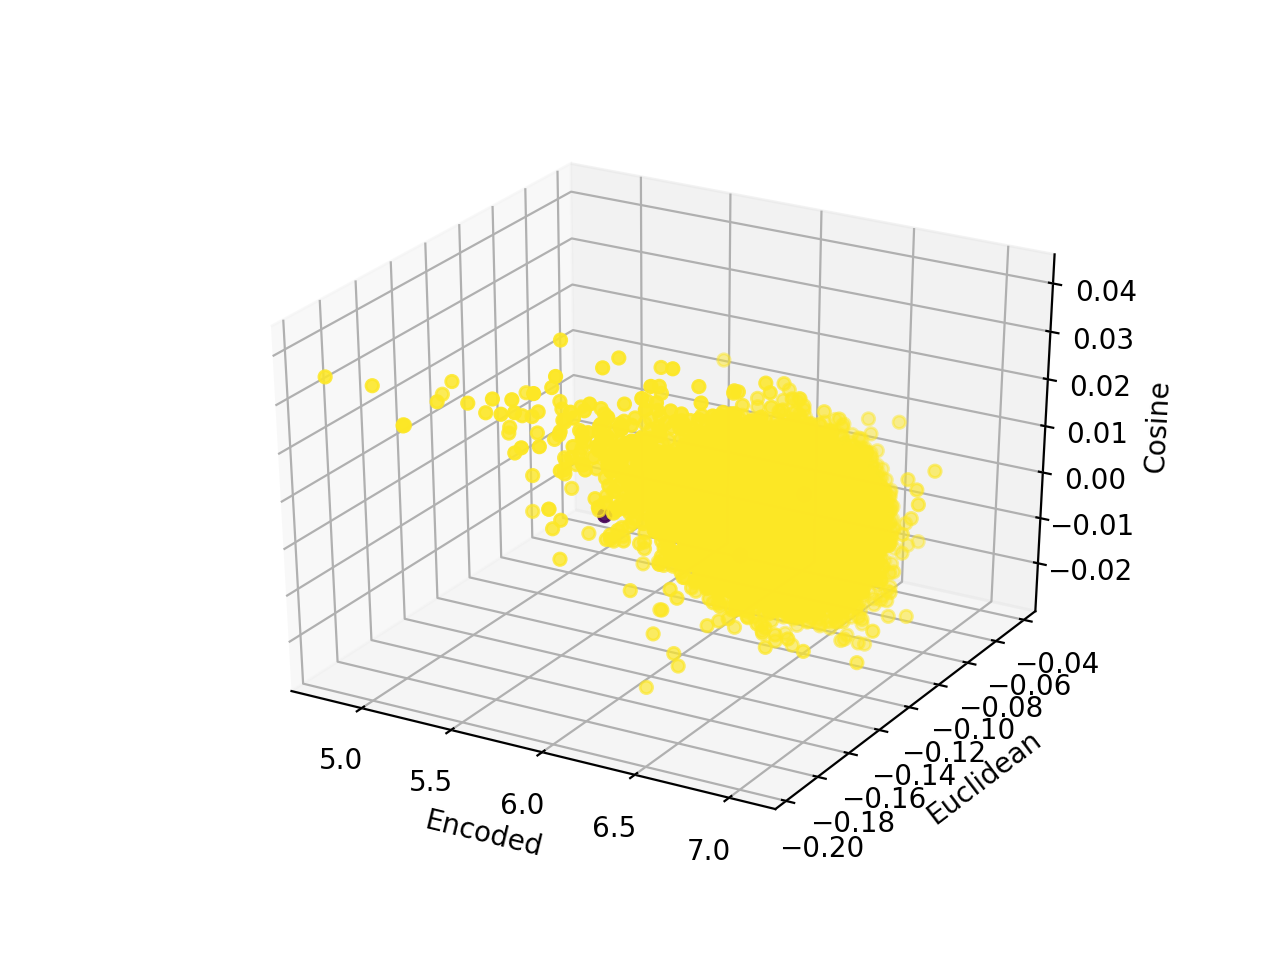

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_z[:,1],test_z[:,0], test_z[:,2], c=test_labels.astype(int))
ax.set_xlabel('Encoded')
ax.set_ylabel('Euclidean')
ax.set_zlabel('Cosine')
plt.show()